In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# PARAMS
use_media = True # Flag for whether the analysis needs to account for media agents
thickness_by_SPIRO = False #whether the trajectory thicknesses scale with SPIRO

 ## Define the file or folder path here
 
 One can either specify a specific file (set the read_specific_file flag to true and set folder path and file title accordingly), or one can read all files in the folder path.

In [3]:
read_specific_file = False


list_file_paths = []
list_file_titles = []


folder_path = "data\\stabilizingNormal" # set the folder path here wrt the ipynb root.

if read_specific_file:
    file_title = "fine-grained-data ___boundaryMean0.35___boundarySD0.2___OpinionMean0___OpinionSD0.2___OpinionDistributionnormal___NetworkTypeScale-free___RS1___MediaOpinions[-0.9 -0.7 0 0.7 0.9]"
    file_name = file_title + ".csv"
    file_path = os.path.join(folder_path, file_name)
    list_file_paths.append(file_path)
    list_file_titles = [file_title]  # Store without extension    
else:
    # Read all CSV files in the folder
    list_dir = os.listdir(folder_path)
    for f in list_dir:
        if f.endswith('.csv'):
            file_path = os.path.join(folder_path, f)
            list_file_paths.append(file_path)
            # Remove the .csv extension and store
            list_file_titles.append(os.path.splitext(f)[0])

        

# Now you can use list_file_titles for reference
print("Found these files: \n")
for title in list_file_titles:
    print(title + "\n")


Found these files: 

epsM0.202_epsSD0___OpDuniform_OpM0_OpSD0.2___NetScale-free___RS1621361533___MedDcentered_MedN10_MedM0_MedSD0.41



In [4]:
# print("Current working directory:", os.getcwd())



 ## Reading metadata then the data
 

In [6]:
from io import StringIO

list_dataframes = [] # list of dataframes for all files in folder
list_metadata_dict = []
list_media_positions = []

for file_path in list_file_paths:
    print(file_path)
    # Read the entire file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    separator = "-----------------"
    sep_indices = [i for i, line in enumerate(lines) if separator in line]

    # Step 1: Extract metadata (before first separator)
    metadata_lines = lines[:sep_indices[0]]
    metadata_df = pd.read_csv(StringIO(''.join(metadata_lines)), header=None)
    metadata_dict = dict(zip(metadata_df[0], metadata_df[1]))
    list_metadata_dict.append(metadata_dict)

    # Step 2: Identify where the main CSV data starts (after last separator)
    data_start_index = sep_indices[-1] + 1
    data_lines = lines[data_start_index:]

    # Step 3: Convert data_lines into a file-like object for pandas
    from io import StringIO
    data_csv = StringIO("".join(data_lines))

    # Step 4: Read it into a dataframe
    this_df = pd.read_csv(data_csv)
    list_dataframes.append(this_df)
        
    # Check each file
    # print("✅ Metadata dictionary:\n", metadata_dict)
    # print("\n✅ Main dataframe columns:\n", df.columns)
    # print("\n✅ First few rows of data:\n", df.head())
    

data\stabilizingNormal\epsM0.202_epsSD0___OpDuniform_OpM0_OpSD0.2___NetScale-free___RS1621361533___MedDcentered_MedN10_MedM0_MedSD0.41.csv


 ## Some needed cleanup

In [8]:
for idf, df in enumerate(list_dataframes):
    # To remove accidental spaces before the column name
    df.columns = df.columns.str.strip()
    if(use_media == True):
        # Clean 'Media-House-Positions' in metadata_dict
        media_str = list_metadata_dict[idf].get('Media-House-Positions', '')  # get the string from metadata
        media_str = media_str.strip('[]')  # remove brackets
        media_positions = [float(x) for x in media_str.split()]  # convert to list of floats
        list_media_positions.append(media_positions)
    # 'opinion' and 'previousOpinion' have leading and ending brackets and need to be converted to numerics
    df['opinion'] = pd.to_numeric(df['opinion'].str.strip("[]"))
    df['previousOpinion'] = pd.to_numeric(df['previousOpinion'].str.strip("[]"))

    # Remove brackets and convert space-separated string into list of ints
    df["influencerIDs"] = df["Influencer ID's"].str.strip("[]").apply(lambda x: [int(i) for i in x.split()])

    # print(df)
    print(list_media_positions)

[[]]


## Opinion Plot

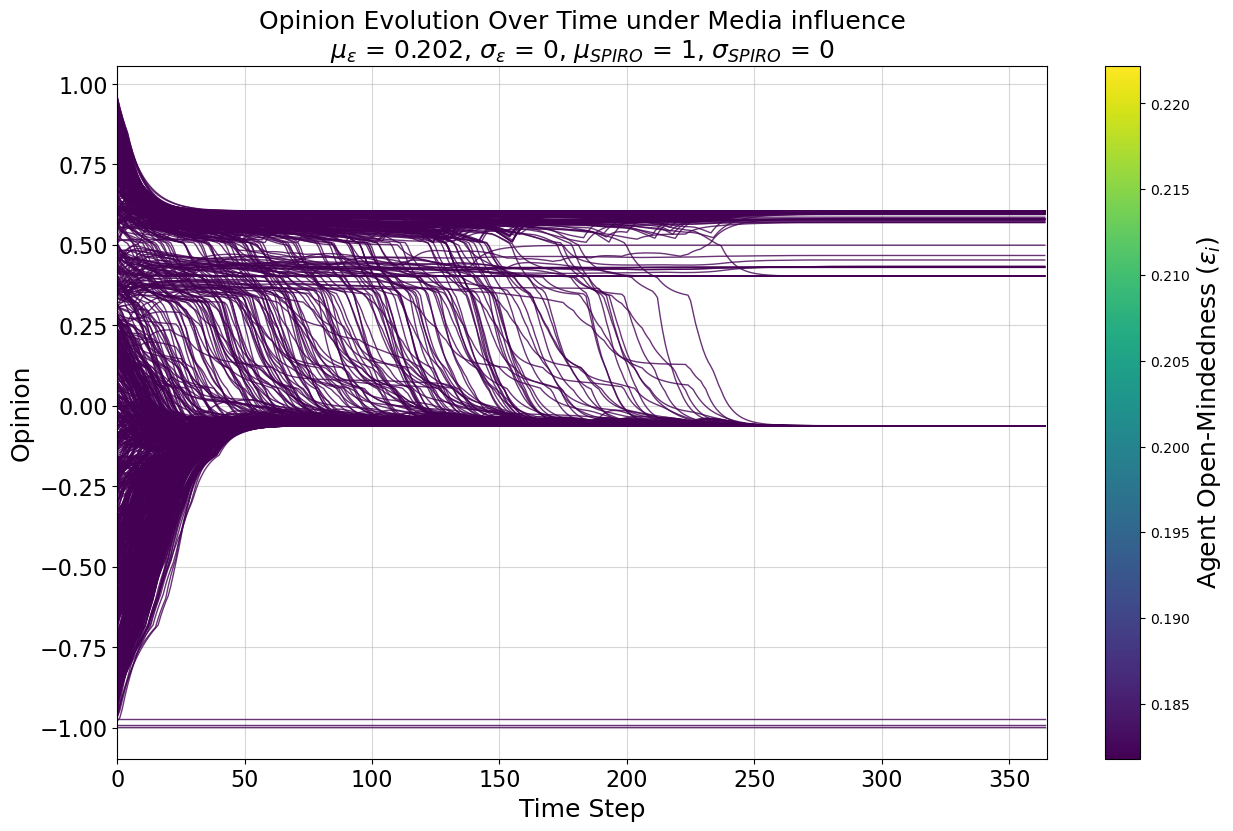

In [10]:

for idf, df in enumerate(list_dataframes):
# Extract metadata values
    mu_epsilon = list_metadata_dict[idf]["boundary-mean"]  # Mean boundary
    sigma_epsilon = list_metadata_dict[idf]["boundary-sd"]  # Std boundary
    mu_SPIRO = list_metadata_dict[idf]["SPIRO-mean"]  # Mean SPIRO
    sigma_SPIRO = list_metadata_dict[idf]["SPIRO-sd"]  # Std SPIRO


    # Normalize boundary values to a colormap range (0 to 1)
    norm = plt.Normalize(df["boundary"].min(), df["boundary"].max())
    cmap = plt.cm.viridis  # Choose colormap
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)  # Create color mapping

    # Sort agents by boundary in ascending order
    sorted_agents = df.groupby("agentID").first().sort_values(by="boundary").index

    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 9))

    # Loop through each agent in sorted order (low boundary first, high boundary last)
    for agent_id in sorted_agents:
        agent_data = df[df["agentID"] == agent_id]

        if(thickness_by_SPIRO):
            linewidth = 1.5 + 2*(0.25 - agent_data["SPIRO"].iloc[0])
        else:
            linewidth = 1 # Haardcoding it away from potentially problematic SPIRO values.

        color = cmap(norm(agent_data["boundary"].iloc[0]))  # Pick color based on first boundary value
        ax.plot(agent_data["timeStep"], agent_data["opinion"], color=color, alpha=0.8, linewidth=linewidth)

    if(use_media):
        # Plot horizontal lines for media opinions
        for i, media_opinion in enumerate(list_media_positions[idf]):
            ax.axhline(y=media_opinion, color='red', linestyle='--', linewidth=2, alpha=0.7)
            ax.text(
                x=370,  # Just outside the x-limit for a neat label
                y=media_opinion,
                s=f"Media {i+1}",
                color='red',
                va='center',
                fontsize=12,
                fontweight='bold'
            )

    # Add colorbar
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label("Agent Open-Mindedness ($\\epsilon_{i}$)", fontsize = 18)

    # Labels and title
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlim([0, 365])
    ax.set_xlabel("Time Step", fontsize = 18)
    ax.set_ylabel(f"Opinion", fontsize = 18)
    # LaTeX formatted title with subscripts
    ax.set_title(
        f"Opinion Evolution Over Time under Media influence\n"
        f"$\\mu_\\epsilon$ = {mu_epsilon}, $\\sigma_\\epsilon$ = {sigma_epsilon}, "
        f"$\\mu_{{SPIRO}}$ = {mu_SPIRO}, $\\sigma_{{SPIRO}}$ = {sigma_SPIRO}", fontsize = 18
    )
    ax.grid(True, linestyle="-", alpha=0.5)


    this_figure_path = os.path.join(folder_path, list_file_titles[idf] + ".png")
    plt.savefig(this_figure_path, dpi=200, bbox_inches='tight')

    # Show the plot
    plt.show()


In [11]:
# from PIL import Image
# import glob

# # Create and save individual frames
# for t in np.arange(365):
#     plt.figure(figsize=(10, 6))
#     t_data = df[df["timeStep"] == t]
#     plt.hist(t_data["opinion"], bins=200, range=(-1, 6))
#     plt.xlim(-1, 1)
#     plt.ylim(0, 550)
#     plt.title(f'Time Step: {t}')
#     plt.savefig(f'temp/frame_{t:03d}.png')
#     plt.close()

# # Combine into GIF (requires ImageMagick)
# frames = [Image.open(img) for img in sorted(glob.glob("temp/frame_*.png"))]
# frames[0].save('opinion_evolution.gif',
#                format='GIF',
#                append_images=frames[1:],
#                save_all=True,
#                duration=150,  # ms per frame
#                loop=0)

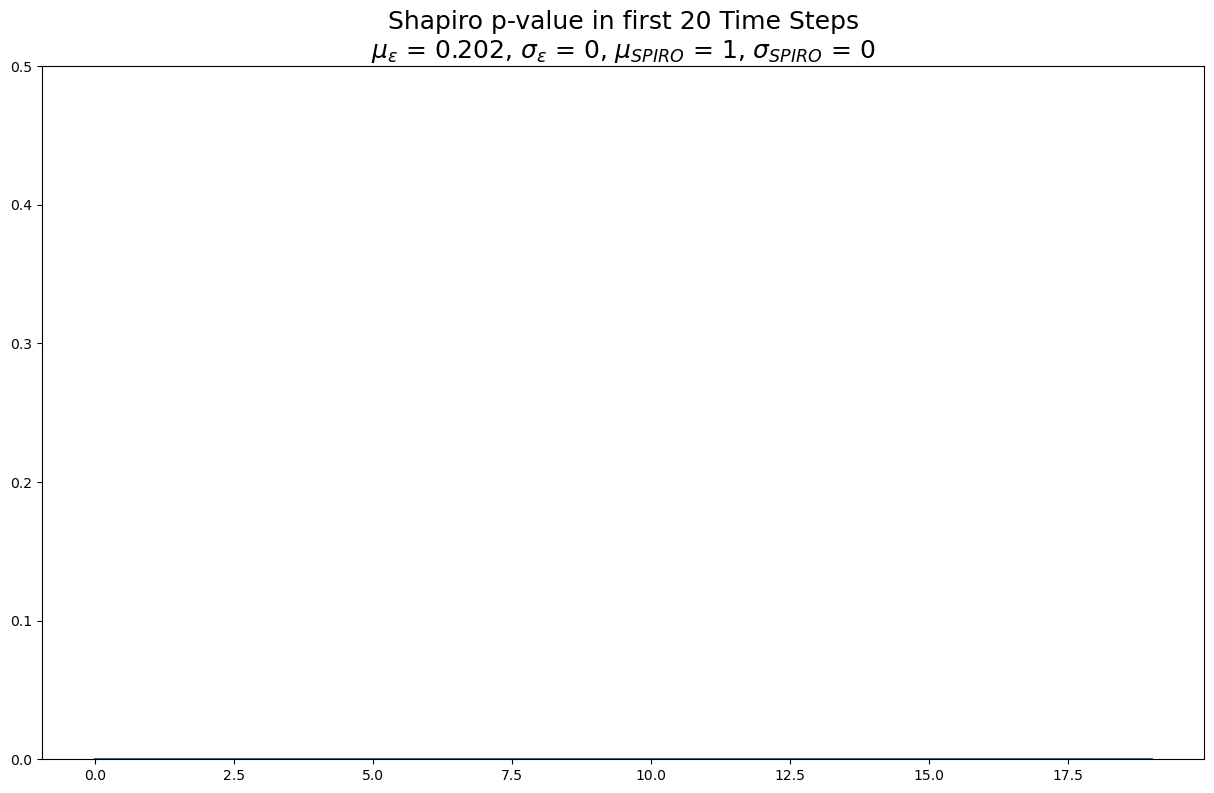

In [12]:
# Testing Normality


from scipy.stats import lognorm
import statsmodels.api as sm
from scipy.stats import shapiro 

for df in list_dataframes:
    shapiro_data = np.array([])

    for t in np.arange(0, 20):

        # plt.figure(figsize=(10, 6))
        t_data = df[df["timeStep"] == t]

        #create Q-Q plot with 45-degree line added to plot
        # fig = sm.qqplot(t_data["opinion"], line='45')
        shapiro_data = np.append(shapiro_data, shapiro(t_data["opinion"]).pvalue)
    
    #Plotting the shapiro p value across time
    fig, ax = plt.subplots(figsize=(15, 9))
    plt.plot(shapiro_data)
    plt.ylim([0, 0.5])

    # LaTeX formatted title with subscripts
    ax.set_title(
        f"Shapiro p-value in first 20 Time Steps\n"
        f"$\\mu_\\epsilon$ = {mu_epsilon}, $\\sigma_\\epsilon$ = {sigma_epsilon}, "
        f"$\\mu_{{SPIRO}}$ = {mu_SPIRO}, $\\sigma_{{SPIRO}}$ = {sigma_SPIRO}", fontsize = 18
    )    # print(shapiro_data)

## Seeing Group Structure evolve


In [14]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # ----- First Plot: Number of Unique Groups Over Time -----
# unique_groups_per_time = df.groupby("timeStep")["groupNumber"].nunique()

# # ----- Second Plot: Fraction of Agents in Groups Over Time -----
# # Step 1: Count agents in each group at each time step
# agents_per_group = df.groupby(["timeStep", "groupNumber"])["agentID"].count()

# # Step 2: Compute total agents per time step
# total_agents_per_time = agents_per_group.groupby("timeStep").sum()

# # Step 3: Convert counts to fractions by dividing each group count by the total agents at that time step
# agents_fraction_per_group = agents_per_group.div(total_agents_per_time, level="timeStep")

# # Step 4: Pivot table to get a wide format (timeStep as rows, group sizes as columns)
# fraction_per_time_wide = agents_fraction_per_group.unstack(fill_value=0)

# # Step 5: Sort each row’s values in descending order (largest groups first)
# sorted_fractions = fraction_per_time_wide.apply(lambda x: sorted(x, reverse=True), axis=1, result_type="expand")

# # ----- Create the Figure with Two Subplots -----
# fig, ax = plt.subplots(figsize=(15, 9))


# # # Second subplot: Stacked Bar Chart of Group Fractions Over Time
# sorted_fractions.plot(kind="bar", stacked=True, ax=axes[1], width=1, cmap="viridis", alpha=0.8)

# # # Formatting for second plot
# # axes[1].set_xlabel("Time Step", fontsize=14)
# # axes[1].set_ylabel("Fraction of Agents", fontsize=14)
# # axes[1].grid(axis="y", linestyle="--", alpha=0.5)
# # axes[1].legend_.remove()  # Hide legend since group numbers aren't meaningful

# # Adjust layout
# plt.tight_layout()
# plt.show()


## Media Houses.